**Automatically generate Irish poetry using Deep Learning**

Import the libraries

In [1]:
#1 
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import numpy as np
print(tf.__version__)

2.9.2


Download the dataset

In [2]:
#2 
import os
dataset_url = "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/irish-lyrics-eof.txt"
filename = os.path.join(os.getcwd(), "irish-lyrics.txt")
tf.keras.utils.get_file(filename, origin=dataset_url)

68970/68970 [==============================] - 0s 2us/step


'/content/irish-lyrics.txt'

Read the contents of the dataset and add to corpus

In [3]:
#3
corpus = []
with open(filename, 'r') as f:
    for line in f:
        line = line.replace("\n", "")
        corpus.append(line)

corpus[: 10]

['Come all ye maidens young and fair',
 'And you that are blooming in your prime',
 'Always beware and keep your garden fair',
 'Let no man steal away your thyme',
 'For thyme it is a precious thing',
 'And thyme brings all things to my mind',
 'nlyme with all its flavours, along with all its joys',
 'Thyme, brings all things to my mind',
 'Once I and a bunch of thyme',
 'i thought it never would decay']

In [4]:
#4
import itertools
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
word_index = tokenizer.word_index
vocab_size = len(word_index)

print("Word Index Items (first 10) :\n", dict(itertools.islice(word_index.items(), 10)))
print("\n Vocab Size : ", vocab_size)

Word Index Items (first 10) :
 {'the': 1, 'and': 2, 'i': 3, 'to': 4, 'a': 5, 'of': 6, 'my': 7, 'in': 8, 'me': 9, 'for': 10}

 Vocab Size :  2689


Convert all text to corresponding tokens and generate all combinations of inputs

In [5]:
#5
input_sequences = []
sequences = tokenizer.texts_to_sequences(corpus)

for sequence in sequences:
    for i in range(1, len(sequence)):
        n_gram = sequence[: i + 1]
        input_sequences.append(n_gram)

input_sequences[: 10]

[[51, 12],
 [51, 12, 96],
 [51, 12, 96, 1217],
 [51, 12, 96, 1217, 48],
 [51, 12, 96, 1217, 48, 2],
 [51, 12, 96, 1217, 48, 2, 69],
 [2, 11],
 [2, 11, 15],
 [2, 11, 15, 31],
 [2, 11, 15, 31, 361]]

Pad the input sequences and get x & y

In [6]:
#6
MAX_LENGTH = max(len(n_gram) for n_gram in input_sequences)
padded = pad_sequences(input_sequences, maxlen=MAX_LENGTH, padding='pre')


x, labels = padded[:, : -1], padded[:, -1]

# one-hot encode the labels
y = tf.keras.utils.to_categorical(labels, num_classes=vocab_size + 1)

Define the model

In [7]:
#7
model = Sequential([
    Embedding(input_dim=vocab_size + 1, output_dim=128, input_length=MAX_LENGTH - 1),
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dense(100, 'relu'),
    Dense(vocab_size + 1, 'softmax')
])

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 128)           344320    
                                                                 
 lstm (LSTM)                 (None, 15, 128)           131584    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 100)               6500      
                                                                 
 dense_1 (Dense)             (None, 2690)              271690    
                                                                 
Total params: 803,502
Trainable params: 803,502
Non-trainable params: 0
_________________________________________________________________


Fit

In [9]:
#8
history = model.fit(x, y, epochs=10)

Epoch 1/10
377/377 [==============================] - 21s 54ms/step - loss: 4.5939 - accuracy: 0.1547
Epoch 2/10
377/377 [==============================] - 20s 54ms/step - loss: 4.4943 - accuracy: 0.1588
Epoch 3/10
377/377 [==============================] - 21s 55ms/step - loss: 4.4102 - accuracy: 0.1645
Epoch 4/10
377/377 [==============================] - 22s 58ms/step - loss: 4.3225 - accuracy: 0.1685
Epoch 5/10
377/377 [==============================] - 21s 54ms/step - loss: 4.2324 - accuracy: 0.1774
Epoch 6/10
377/377 [==============================] - 21s 55ms/step - loss: 4.1416 - accuracy: 0.1817
Epoch 7/10
377/377 [==============================] - 20s 54ms/step - loss: 4.0490 - accuracy: 0.1915
Epoch 8/10
377/377 [==============================] - 23s 61ms/step - loss: 3.9618 - accuracy: 0.2003
Epoch 9/10
377/377 [==============================] - 21s 55ms/step - loss: 3.8655 - accuracy: 0.2074
Epoch 10/10
377/377 [==============================] - 21s 55ms/step - loss: 3.780

Plot the accuracy & loss graph

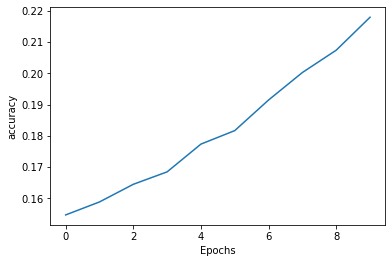

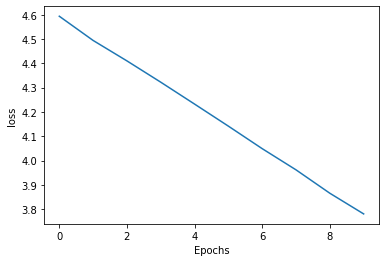

In [10]:
#9
import matplotlib.pyplot as plt
def plot_graphs(val):
    plt.plot(history.history[val])
    plt.xlabel('Epochs')
    plt.ylabel(val)
    plt.show()

plot_graphs('accuracy')
plot_graphs('loss')

Predict!

In [12]:
#10
import random
seed_text = 'Then came a sailor'
next_words = 100

for _ in range(next_words):
    sequence = tokenizer.texts_to_sequences([seed_text])[0]
    padded = pad_sequences([sequence], maxlen=MAX_LENGTH - 1, padding='pre')
    #predicted = model.predict_classes(padded)
    predicted = np.argmax(model.predict(padded),axis=1)
    output_word = ''

    for word, index in word_index.items():
        if index == predicted:
            output_word = word
            break

    seed_text += f' {output_word}'

# print in the format of a poetry
words = seed_text.split(" ")
text = ""
count = 0
for word in words:
  count += 1
  r = random.randint(8, 16)
  if count >= r :
    count = 0
    text += f' {word} \n'
  else:
    text += f' {word}'

print(text)

1/1 [==============================] - 0s 25ms/step
 Then came a sailor should a heart and the sun that i 
 can see the wild rover oer you i took a wild 
 rover oer the wild gardens to more taken i said 
 you be unto take a man is be up a 
 health to the bridge of toome today and 
 brave and heavenward of heavem a heart of the town 
 eyes spleen i was taken a wild flower oer the 
 bow is you i was born in ballyjamesduff and thee 
 i go roamin from a ball swings the bow is 
 the town of doneen rosin the bow is 
 the town and eer the


And that's it! This is a poetry generated by your Deep Learning NLP model based on the Irish poetry dataset from Laurence Moroney.

The model has been fine-tuned previously so as not to have repetitions.

I have deliberately not used a Bidirectional LSTM as we're always predicting the next word.